In [ ]:
import importlib
import utilityFunctions
importlib.reload(utilityFunctions)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<module 'utilityFunctions' from '/workspaces/mlops-fake-news-prediction/utilityFunctions.py'>

In [2]:
import seaborn as sns
import pandas as pd
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from utilityFunctions import clean_data, prepare_features, apply_text_cleaner, remove_outliers, evaluate

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
df = pd.read_csv('data/WELFake_Dataset.csv')

In [4]:
# Remove duplicates so that they do not end up in the validation and test data set
df = df.drop_duplicates(subset='text').reset_index().drop(columns='index')
df = df.drop_duplicates(subset='title').reset_index().drop(columns='index')

In [5]:
# path = './data/Dataset_cleaned.csv'

# with open(path, 'r', encoding='utf-8') as file:
    # df_cleaned = pd.read_csv(file)

# df_cleaned.head()

In [5]:
X = df.drop(columns='label')
y = df.loc[:, 'label']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                    y_train, 
                                                    test_size=0.25, 
                                                    random_state=42)

In [6]:
X_train, y_train = clean_data(X_train, y_train)
X_val, y_val = clean_data(X_val, y_val)
X_test, y_test = clean_data(X_test, y_test)

X_train = prepare_features(X_train)
X_val = prepare_features(X_val)
X_test = prepare_features(X_test)

In [7]:
num_cols = X_train.select_dtypes(include=['number']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

In [8]:
X_train = apply_text_cleaner(X_train, column='title_text')

Progress: 100%|██████████| 36840/36840 [43:01<00:00, 14.27it/s]  


In [20]:
X_val = apply_text_cleaner(X_val, column='title_text')
X_test = apply_text_cleaner(X_test, column='title_text')

Progress: 100%|██████████| 12281/12281 [13:57<00:00, 14.67it/s]


In [21]:
X_train.to_parquet('./data/X_train.parquet', index=False)
X_val.to_parquet('./data/X_val.parquet', index=False)
X_test.to_parquet('./data/X_test.parquet', index=False)

In [9]:
print(len(X_train))

X_train_without_outliers, y_train_without_outliers = remove_outliers(X_train, y_train, num_cols, threshold=3, iterations=1)

print(len(X_train))

36840
0
36840


In [10]:
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.pipeline import Pipeline

# num_cols = df_cleaned.select_dtypes(include=['number']).columns.drop('label')
# text_col = 'title_text_clean'

# preprocessor = ColumnTransformer([
#     ('num', StandardScaler(), num_cols),
#     ('text', CountVectorizer(), text_col)
# ])

# X_train = preprocessor.fit_transform(X_train)
# X_test = preprocessor.transform(X_test)

# print(X_train.toarray())

In [11]:
count_vectorizer = CountVectorizer()
X_train_bow = count_vectorizer.fit_transform(X_train['title_text_clean'])
X_test_bow = count_vectorizer.transform(X_test['title_text_clean'])

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x707ec6285910>>
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyError: 'title_text_clean'

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['title_text_clean'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['title_text_clean'])

In [ ]:
print(f"X_train_bow Shape: {X_train_bow.shape}")  
print(f"y_train Shape: {y_train.shape}")

X_train_bow Shape: (50493, 193752)
y_train Shape: (50493,)


# Baseline model

              precision    recall  f1-score   support

        Real       0.94      0.95      0.94     11028
        Fake       0.95      0.94      0.94     10613

    accuracy                           0.94     21641
   macro avg       0.94      0.94      0.94     21641
weighted avg       0.94      0.94      0.94     21641



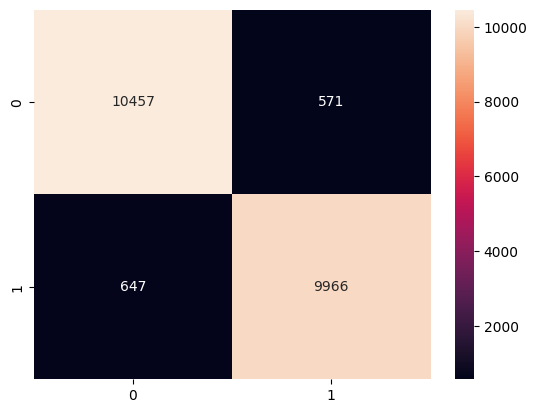

In [ ]:
rf_baseline = RandomForestClassifier(random_state=0)
rf_baseline.fit(X_train_bow, y_train)
y_pred_baseline = rf_baseline.predict(X_test_bow)
evaluate(y_test, y_pred_baseline)

In [ ]:
rf_baseline.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [ ]:
rf_classifier_bow = RandomForestClassifier(n_estimators=100, max_depth=12, class_weight='balanced', random_state=0)

rf_classifier_bow.fit(X_train_bow, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=0)

              precision    recall  f1-score   support

        Real       0.86      0.92      0.89     11028
        Fake       0.91      0.85      0.88     10613

    accuracy                           0.88     21641
   macro avg       0.88      0.88      0.88     21641
weighted avg       0.88      0.88      0.88     21641



<Axes: >

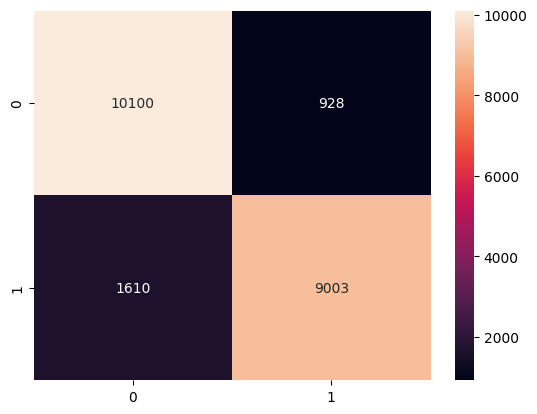

In [ ]:
y_test_pred_rf = rf_classifier_bow.predict(X_test_bow)
print(classification_report(y_test, y_test_pred_rf, target_names=["Real", "Fake"]))
cm = confusion_matrix(y_test, y_test_pred_rf)

sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
rf_classifier_tfidf = RandomForestClassifier(n_estimators=300, max_depth=12, class_weight='balanced', random_state=0)

rf_classifier_tfidf.fit(X_train_tfidf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=300,
                       random_state=0)

              precision    recall  f1-score   support

        Real       0.88      0.91      0.90     11028
        Fake       0.91      0.87      0.89     10613

    accuracy                           0.89     21641
   macro avg       0.90      0.89      0.89     21641
weighted avg       0.89      0.89      0.89     21641



<Axes: >

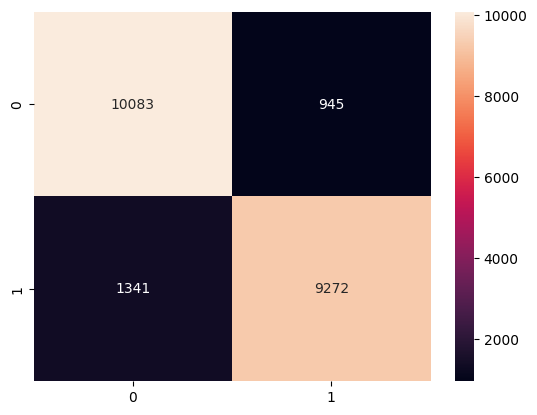

In [ ]:
y_test_pred_rf_tfidf = rf_classifier_tfidf.predict(X_test_tfidf)
print(classification_report(y_test, y_test_pred_rf_tfidf, target_names=["Real", "Fake"]))

cm = confusion_matrix(y_test, y_test_pred_rf_tfidf)

sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
print(df_cleaned.shape)
df_no_duplicates = df_cleaned.drop_duplicates(subset=['title', 'text'])
df_no_duplicates.shape

(72134, 14)


(63678, 14)

In [ ]:
X_no_dupl = df_no_duplicates.drop(columns=['title', 'text', 'label', 'title_text'])
y_no_dupl = df_no_duplicates.loc[:, 'label']

X_train_no_dupl, X_test_no_dupl, y_train_no_dupl, y_test_no_dupl = train_test_split(X_no_dupl, 
                                                    y_no_dupl, 
                                                    test_size=0.3, 
                                                    random_state=42)

count_vectorizer = CountVectorizer()
X_train_bow_np = count_vectorizer.fit_transform(X_train_no_dupl['title_text_clean'])
X_test_bow_np = count_vectorizer.transform(X_test_no_dupl['title_text_clean'])

              precision    recall  f1-score   support

        Real       0.85      0.89      0.87      8588
        Fake       0.91      0.87      0.89     10516

    accuracy                           0.88     19104
   macro avg       0.88      0.88      0.88     19104
weighted avg       0.88      0.88      0.88     19104



<Axes: >

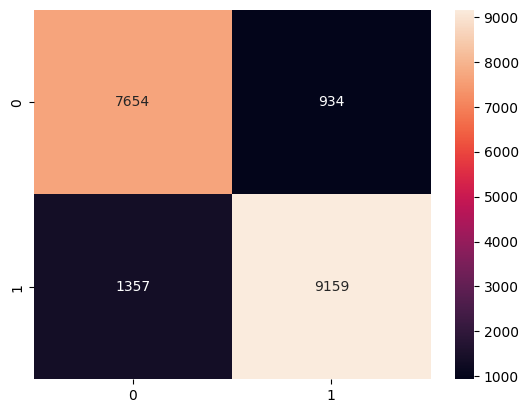

In [ ]:
rf_classifier_bow_np = RandomForestClassifier(n_estimators=100, max_depth=12, class_weight='balanced', random_state=0)
rf_classifier_bow_np.fit(X_train_bow_np, y_train_no_dupl)

y_test_pred_rf_np = rf_classifier_bow_np.predict(X_test_bow_np)
print(classification_report(y_test_no_dupl, y_test_pred_rf_np, target_names=["Real", "Fake"]))
cm = confusion_matrix(y_test_no_dupl, y_test_pred_rf_np)

sns.heatmap(cm, annot=True, fmt='d')